# Customer Reviews Classification

## 1. **Problem Statement**
You are working in an e-commerce company, and your company has put forward a task to
analyze the customer reviews for various products. You are supposed to create a report that
classifies the products based on the customer reviews.

Need Reviews Data Set? https://www.kaggle.com/datasets/tajamulkhan/reviews-dataset

## 2. **Project Objective**

Find various trends and patterns in the reviews data, create useful insights that
best describe the product quality.

Classify each review based on the sentiment associated with the same

## 3. **Data Description**

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm   # tqdm is for printing the status bar
from bs4 import BeautifulSoup

# library for splitting the dataset
from sklearn.model_selection import train_test_split

# libraries for featurization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

# library for modeling
from sklearn.naive_bayes import MultinomialNB

#  library for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# evaluation of model
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re



In [ ]:
data = pd.read_csv('Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data=data[data['Score']!=3]  #  we will not consider reviews with 'Score' 3, so we are droping all the rows with 'Score' feature equals 3
data.shape

(360946, 10)

In [ ]:
def partition(x):  # given x it returns 1 if x>3 else returns 0
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negative(0) and greater the 3 to be positive(1)
actual_score = data['Score']
positive_negative = actual_score.map(partition)
data['Score'] = positive_negative
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data['Score'].value_counts()

1    304048
0     56898
Name: Score, dtype: int64

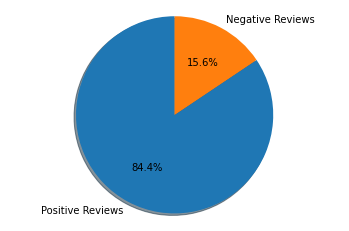

In [ ]:
labels = 'Positive Reviews', 'Negative Reviews'
sizes = [443777, 82037]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
sorted_data = data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Droping Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(263286, 10)

In [ ]:
def decontracted(phrase):  # this function expands english language contraction such as (that's) to ('that is')
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
## Preprocessing 'Text' column
# The Below code removes url's , html tags, words with numbers, special character, stopwords and decontracts words in the Text for each review

preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 263286/263286 [01:38<00:00, 2664.50it/s]


In [ ]:
# Preprocessing Summary column
# The Below code removes url's , html tags, words with numbers, special character, stopwords and decontracts words in the Summary for each review

preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", str(sentance))
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_Summary.append(sentance.strip())

100%|██████████| 263286/263286 [01:06<00:00, 3966.40it/s]


In [ ]:
# let's replace the 'Summary' and 'Text' column with the preprocessed data.
final["Summary"] = preprocessed_Summary
final['Text'] = preprocessed_reviews
final.drop(['Id', 'ProductId', 'UserId', 'ProfileName'], axis = 1, inplace=True)  # not considering these columns for classification.

In [ ]:
final.reset_index(inplace=True)

In [ ]:
final.drop(['index'], axis=1, inplace=True)
final.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,0,1,1096675200,mmmm chicken soup,summary young boy describes usefulness chicken...
1,0,0,1,1256688000,great gift,book purchased birthday gift year old boy sque...
2,0,0,1,1256774400,great book,always loved chicken soup rice late great gran...
3,0,0,1,1288224000,love book,great book perfect condition arrived short amo...
4,0,0,1,1291075200,good children,classic children book not go wrong read kid or...


In [ ]:
y = final['Score'].values
X = final.drop(['Score'], axis=1)

# splitting the data and class labels in to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [ ]:
print('train data shape', X_train.shape)
print('train data labels shape ', y_train.shape)
print('test data shape', X_test.shape)
print('test data labels shape', y_test.shape)

train data shape (176401, 5)
train data labels shape  (176401,)
test data shape (86885, 5)
test data labels shape (86885,)


In [ ]:
### Text feature
# calling the CountVectorizer class with three parameters
vectorizer = CountVectorizer(min_df=10, ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['Text'].values) # fitting the model with train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_text = vectorizer.transform(X_train['Text'].values)
X_test_text = vectorizer.transform(X_test['Text'].values)

# getting the features
features_text = vectorizer.get_feature_names() # we will be using this afterwords

print("After vectorizations using BOW")
print(X_train_text.shape, y_train.shape)
print(X_test_text.shape, y_test.shape)

After vectorizations using BOW
(176401, 5000) (176401,)
(86885, 5000) (86885,)


In [ ]:
################# Summary feature ##################
# calling the CountVectorizer class with three parameters
vectorizer = CountVectorizer(min_df=10, ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['Summary'].values) # fitting the model with train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_summary = vectorizer.transform(X_train['Summary'].values)
X_test_summary = vectorizer.transform(X_test['Summary'].values)

# getting the features of bow vectorization
features_summary = vectorizer.get_feature_names() # we will be using this afterwords

print("After vectorizations using BOW")
print(X_train_summary.shape, y_train.shape)
print(X_test_summary.shape, y_test.shape)

After vectorizations using BOW
(176401, 5000) (176401,)
(86885, 5000) (86885,)


In [ ]:
# "HelpfulnessNumerator" feature
normalizer = Normalizer() # normalizing numerical features such that all numerical features are in same range.

normalizer.fit(X_train['HelpfulnessNumerator'].values.reshape(-1,1))

X_train_help_num_norm = normalizer.transform(X_train['HelpfulnessNumerator'].values.reshape(1,-1)).reshape(-1,1)
X_test_help_num_norm = normalizer.transform(X_test['HelpfulnessNumerator'].values.reshape(1,-1)).reshape(-1,1)


print("After normalization of price feature")
print(X_train_help_num_norm.shape, y_train.shape)
print(X_test_help_num_norm.shape, y_test.shape)
print("="*100)

ValueError: ignored

In [ ]:
# "HelpfulnessDenominator" feature
normalizer = Normalizer()

normalizer.fit(X_train['HelpfulnessDenominator'].values.reshape(-1,1))

X_train_help_den_norm = normalizer.transform(X_train['HelpfulnessDenominator'].values.reshape(1,-1)).reshape(-1,1)
X_test_help_den_norm = normalizer.transform(X_test['HelpfulnessDenominator'].values.reshape(1,-1)).reshape(-1,1)


print("After normalization of price feature")
print(X_train_help_den_norm.shape, y_train.shape)
print(X_test_help_den_norm.shape, y_test.shape)
print("="*100)

In [ ]:
# "Time" feature
normalizer = Normalizer()

normalizer.fit(X_train['Time'].values.reshape(-1,1))

X_train_time_norm = normalizer.transform(X_train['Time'].values.reshape(1,-1)).reshape(-1,1)
X_test_time_norm = normalizer.transform(X_test['Time'].values.reshape(1,-1)).reshape(-1,1)


print("After normalization of price feature")
print(X_train_time_norm.shape, y_train.shape)
print(X_test_time_norm.shape, y_test.shape)
print("="*100)

In [ ]:
from scipy.sparse import hstack

X_tr = hstack((X_train_text, X_train_summary, X_train_help_num_norm,  # train data after BOW representation for 'Text' and 'Summary' feature.
                   X_train_help_den_norm, X_train_time_norm)).tocsr()

X_te = hstack((X_test_text, X_test_summary, X_test_help_num_norm,  # test data after BOW representation for 'Text' and 'Summary' feature.
                   X_test_help_den_norm, X_test_time_norm)).tocsr()


print("Final Data matrix with BOW representation for essay")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

In [ ]:
from sklearn.model_selection import GridSearchCV

NB_classifier = MultinomialNB(class_prior=[0.5, 0.5])

parameters = {'alpha': [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 10, 20, 25, 30, 50, 70, 100]}  # various values of alhap's to choose from.
clf = GridSearchCV(NB_classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True)  # gridsearchCV with 5 fold cross validation .
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])


In [ ]:
cv_auc = results['mean_test_score']      # mean test scores for every 'alpha'
train_auc = results['mean_train_score']  # mean train scores for every 'alpha

alpha =  list(results['param_alpha'])
alpha=np.log(alpha)   # taking log of alphas so to make the plot more readable

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log(alpha): hyperparameters")
plt.ylabel("AUC")
plt.title("Hyper parameters Vs AUC plot")
plt.grid()
plt.show()

In [ ]:
clf.best_estimator_ # using this estimator lets predict the labels of test dataset

In [ ]:
NBclassifier = MultinomialNB(alpha=0.2, class_prior=[0.5, 0.5], fit_prior=True)
NBclassifier.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = NBclassifier.predict_proba(X_tr)[:,1]     # predicted probabilities of train datapoints belonging to positive class
y_test_pred = NBclassifier.predict_proba(X_te)[:,1]      # predicted probabilities of test datapoints belonging to positive class

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)   # fpr and tpr for train data
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)       # fpr and tpr for test data

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.grid()
plt.show()

In [ ]:

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)  # getting the best threshold for separating the positive classes form negative

test_confusion_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))  # calculates the confusion matrix


In [ ]:


group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                test_confusion_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

print("Test confusion matrix")
sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Oranges',cbar=False, xticklabels=['Prediction:Negative', 'Prediction:Positive'], yticklabels=['Actal:Negative', 'Actual:Positive'])

In [ ]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(test_confusion_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
list_of_features = features_text + features_summary + ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']

In [ ]:
# Top 20 features form negative class
features = np.argsort(NBclassifier.feature_log_prob_[0]) # sorting the features log probability for negtive class
                                                             #  form low probability to high probability and getting its indice

features = features[::-1]  # reversing it form high probability to low probability indice

for i in features[:20]:  # printing top 20 features from negative calss
    print(list_of_features[i])

In [ ]:
# Top 20 features form negative class
features = np.argsort(NBclassifier.feature_log_prob_[1]) # sorting the features log probability for negtive class
                                                             #  form low probability to high probability and getting its indice

features = features[::-1]  # reversing it form high probability to low probability indice

for i in features[:20]:  # printing top 20 features from negative calss
    print(list_of_features[i])